In [15]:
import os, sys
import time

from pprint import pprint
from collections import defaultdict

import matplotlib.pyplot as plt

import bz2
import gzip
import zlib

In [16]:
sklearn_path = (
    "/home/nano/projects/tree-ensemble-model-management/models/sklearn/5days/100_trees"
)

xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost/5days"

In [17]:
def xor_bytes(byte_str1, byte_str2):
    # Determine the length of the shorter byte string
    min_len = min(len(byte_str1), len(byte_str2))

    # XOR each pair of bytes up to the length of the shorter byte string
    result = bytes([a ^ b for a, b in zip(byte_str1[:min_len], byte_str2[:min_len])])

    # Append any remaining bytes from the longer byte string
    if len(byte_str1) > len(byte_str2):
        result += byte_str1[min_len:]
    elif len(byte_str2) > len(byte_str1):
        result += byte_str2[min_len:]

    return result

In [18]:
def get_diff_stats(model_folder, compression_func):
    stats = {
        "baseline": [],
        "baseline_compressed": [],
        "diff_uncompressed": [],
        "diff_compressed": [],
    }

    model_files = os.listdir(model_folder)

    # Read all model binary strings
    model_binaries = []
    for model_file in model_files:
        with open(os.path.join(model_folder, model_file), "rb") as f:
            model_binary = f.read()
        model_binaries.append(model_binary)

    model_binaries_compressed = [compression_func(model) for model in model_binaries]

    for model_idx in range(0, len(model_files) - 1):
        current_model = model_binaries[model_idx]
        next_model = model_binaries[model_idx + 1]

        current_model_compressed = model_binaries_compressed[model_idx]
        next_model_compressed = model_binaries_compressed[model_idx + 1]

        xor_uncompressed = xor_bytes(current_model, next_model)
        xor_compressed = xor_bytes(current_model_compressed, next_model_compressed)

        xor_compressed_compressed = compression_func(xor_compressed)
        xor_uncompressed_compressed = compression_func(xor_uncompressed)

        baseline = len(current_model) + len(next_model)
        baseline_compressed = len(current_model_compressed) + len(next_model_compressed)
        diff_uncompressed = len(current_model_compressed) + len(
            xor_uncompressed_compressed
        )
        diff_compressed = len(current_model_compressed) + len(xor_compressed_compressed)

        stats["baseline_compressed"].append(baseline/ baseline_compressed)
        stats["diff_uncompressed"].append(baseline/ diff_uncompressed)
        stats["diff_compressed"].append(baseline/ diff_compressed)

    return stats

In [23]:
stats = get_diff_stats(sklearn_path, bz2.compress)

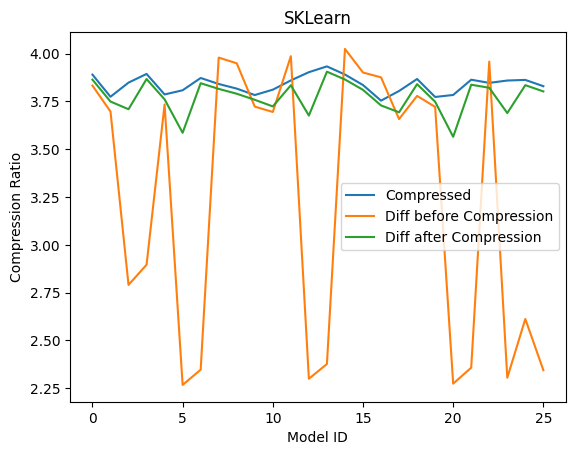

In [24]:
plt.title("SKLearn")
plt.plot(stats["baseline_compressed"], label="Compressed")
plt.plot(stats["diff_uncompressed"], label="Diff before Compression")
plt.plot(stats["diff_compressed"], label="Diff after Compression")
plt.xlabel("Model ID")
plt.ylabel("Compression Ratio")
plt.legend()

In [25]:
stats = get_diff_stats(xgboost_path, bz2.compress)

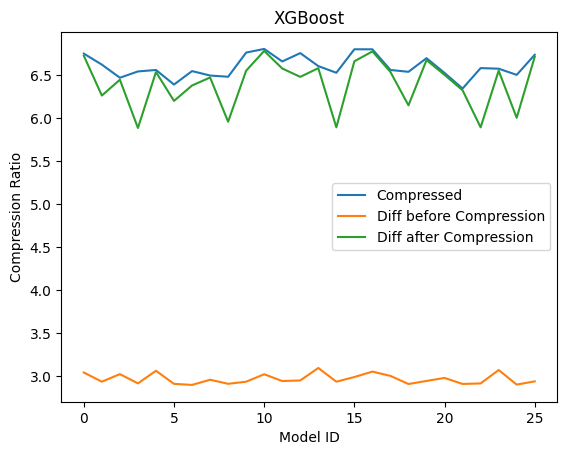

In [26]:

plt.title("XGBoost")
plt.plot(stats["baseline_compressed"], label="Compressed")
plt.plot(stats["diff_uncompressed"], label="Diff before Compression")
plt.plot(stats["diff_compressed"], label="Diff after Compression")
plt.xlabel("Model ID")
plt.ylabel("Compression Ratio")
plt.legend()

## Continuous Diffs

In [51]:
from collections import defaultdict


def multi_model_diffs(model_folder, compression_func):
    stats = {
        "compressed": defaultdict(list),
        "diff_uncompressed": defaultdict(list),
        "diff_compressed": defaultdict(list),
    }
    # List all model
    model_files = os.listdir(model_folder)

    # Read all model binary strings
    model_binaries = []
    for model_file in model_files:
        with open(os.path.join(model_folder, model_file), "rb") as f:
            model_binary = f.read()
        model_binaries.append(model_binary)
    # Compress them all once
    model_binaries_compressed = [compression_func(model) for model in model_binaries]

    # Iterate over all possible window sizes
    for window_size in range(2, len(model_files)):
        print(f"Window Size: {window_size}")

        # Iterate over models in window-size steps
        for start_idx in range(0, len(model_files), window_size):
            end_idx = start_idx + window_size

            if end_idx >= len(model_files):
                break

            # print(f"Models {start_idx} to {end_idx}")

            # Get baseline case
            baseline = sum([len(model) for model in model_binaries[start_idx:end_idx]])
            baseline_compressed = sum(
                [len(model) for model in model_binaries_compressed[start_idx:end_idx]]
            )

            # Diffs on uncompressed models
            diffs = []
            current_binaries = model_binaries[start_idx:end_idx]
            for model_idx in range(len(current_binaries)):
                current_model = model_binaries[model_idx]
                next_model = model_binaries[model_idx + 1]

                if model_idx == 0:
                    diffs.append(current_model)
                else:
                    diffs.append(xor_bytes(current_model, next_model))

            total_size_diff = sum([len(compression_func(diff)) for diff in diffs])

            # Diffs on compressed models
            diffs_compressed = []
            current_binaries_compressed = model_binaries_compressed[start_idx:end_idx]
            for model_idx in range(len(current_binaries_compressed)):
                current_model = model_binaries[model_idx]
                next_model = model_binaries[model_idx + 1]

                if model_idx == 0:
                    diffs_compressed.append(current_model)
                else:
                    diffs_compressed.append(xor_bytes(current_model, next_model))
            diffs_compressed = [compression_func(diff) for diff in diffs_compressed]

            total_size_diff_compressed = sum(
                [len(compression_func(diff)) for diff in diffs_compressed]
            )

            stats["compressed"][window_size].append(baseline / baseline_compressed)
            stats["diff_compressed"][window_size].append(baseline / total_size_diff)
            stats["diff_uncompressed"][window_size].append(
                baseline / total_size_diff_compressed
            )

            # print(
            #     f"Compressed: {baseline/baseline_compressed}, Diff: {baseline/total_size_diff}, Diff-Compressed: {baseline/total_size_diff_compressed}"
            # )

    for window_size in stats["compressed"].keys():
        stats["compressed"][window_size] = sum(stats["compressed"][window_size]) / len(
            stats["compressed"][window_size]
        )
        stats["diff_compressed"][window_size] = sum(
            stats["diff_compressed"][window_size]
        ) / len(stats["diff_compressed"][window_size])
        stats["diff_uncompressed"][window_size] = sum(
            stats["diff_uncompressed"][window_size]
        ) / len(stats["diff_uncompressed"][window_size])

    return stats

In [53]:
stats = multi_model_diffs(xgboost_path, zlib.compress)

Window Size: 2
Window Size: 3
Window Size: 4
Window Size: 5
Window Size: 6
Window Size: 7
Window Size: 8
Window Size: 9
Window Size: 10
Window Size: 11
Window Size: 12
Window Size: 13
Window Size: 14
Window Size: 15
Window Size: 16
Window Size: 17
Window Size: 18
Window Size: 19
Window Size: 20
Window Size: 21
Window Size: 22
Window Size: 23
Window Size: 24
Window Size: 25
Window Size: 26


In [58]:
stats

{'compressed': defaultdict(list,
             {2: 5.370980016054525,
              3: 5.375679912223279,
              4: 5.373492625796929,
              5: 5.3689667491583,
              6: 5.373833168605335,
              7: 5.380964681375148,
              8: 5.373162605359237,
              9: 5.3864469700285795,
              10: 5.381468475935363,
              11: 5.374420748091017,
              12: 5.3730142370110325,
              13: 5.368673359949657,
              14: 5.378657543906487,
              15: 5.368642640280005,
              16: 5.3744847302586685,
              17: 5.383129950901541,
              18: 5.385136123363155,
              19: 5.380705797230199,
              20: 5.380818680873244,
              21: 5.380677504238302,
              22: 5.374352403957878,
              23: 5.368227484907661,
              24: 5.373000210623195,
              25: 5.367419589178962,
              26: 5.368671523425697}),
 'diff_uncompressed': defaultdict(list,
       

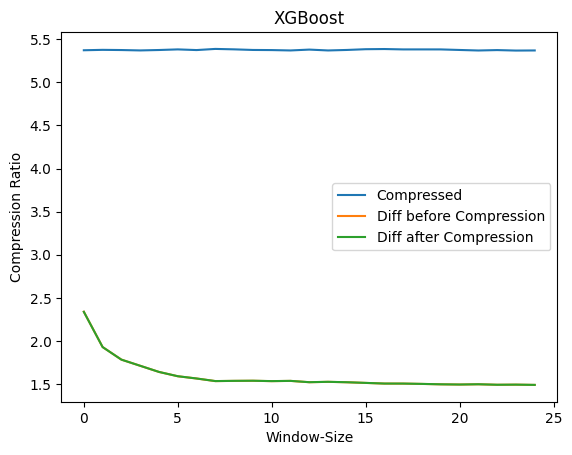

In [61]:
plt.title("XGBoost")
plt.plot(stats["compressed"].values(), label="Compressed")
plt.plot(stats["diff_uncompressed"].values(), label="Diff before Compression")
plt.plot(stats["diff_compressed"].values(), label="Diff after Compression")
plt.xlabel("Window-Size")
plt.ylabel("Compression Ratio")
plt.legend()

In [62]:
stats = multi_model_diffs(sklearn_path, zlib.compress)

Window Size: 2
Window Size: 3
Window Size: 4
Window Size: 5
Window Size: 6
Window Size: 7
Window Size: 8
Window Size: 9
Window Size: 10
Window Size: 11
Window Size: 12
Window Size: 13
Window Size: 14
Window Size: 15
Window Size: 16
Window Size: 17
Window Size: 18
Window Size: 19
Window Size: 20
Window Size: 21
Window Size: 22
Window Size: 23
Window Size: 24
Window Size: 25
Window Size: 26


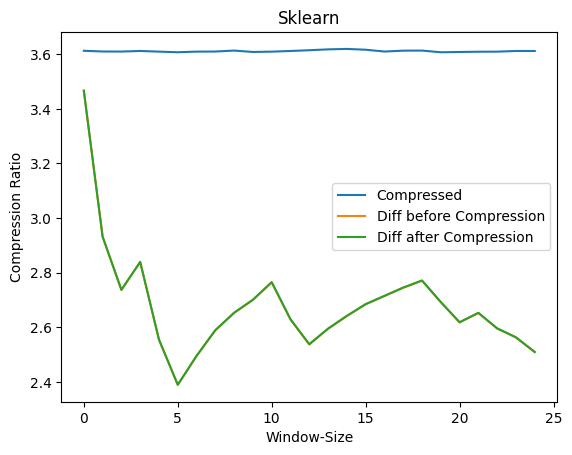

In [63]:
plt.title("Sklearn")
plt.plot(stats["compressed"].values(), label="Compressed")
plt.plot(stats["diff_uncompressed"].values(), label="Diff before Compression")
plt.plot(stats["diff_compressed"].values(), label="Diff after Compression")
plt.xlabel("Window-Size")
plt.ylabel("Compression Ratio")
plt.legend()